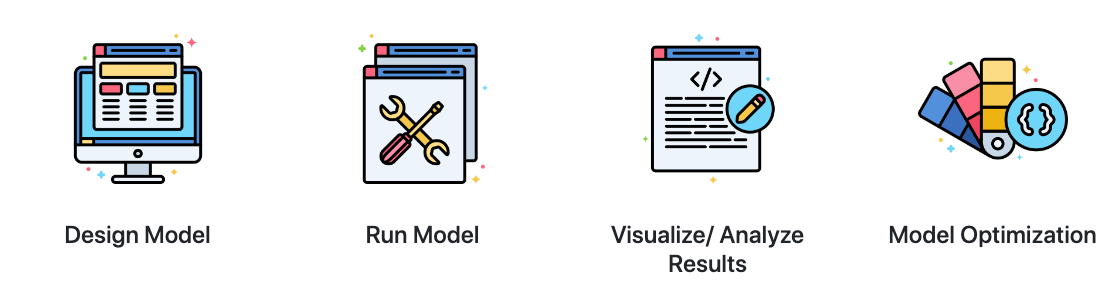

In [26]:
from IPython import display
display.Image("model_simulation.png")

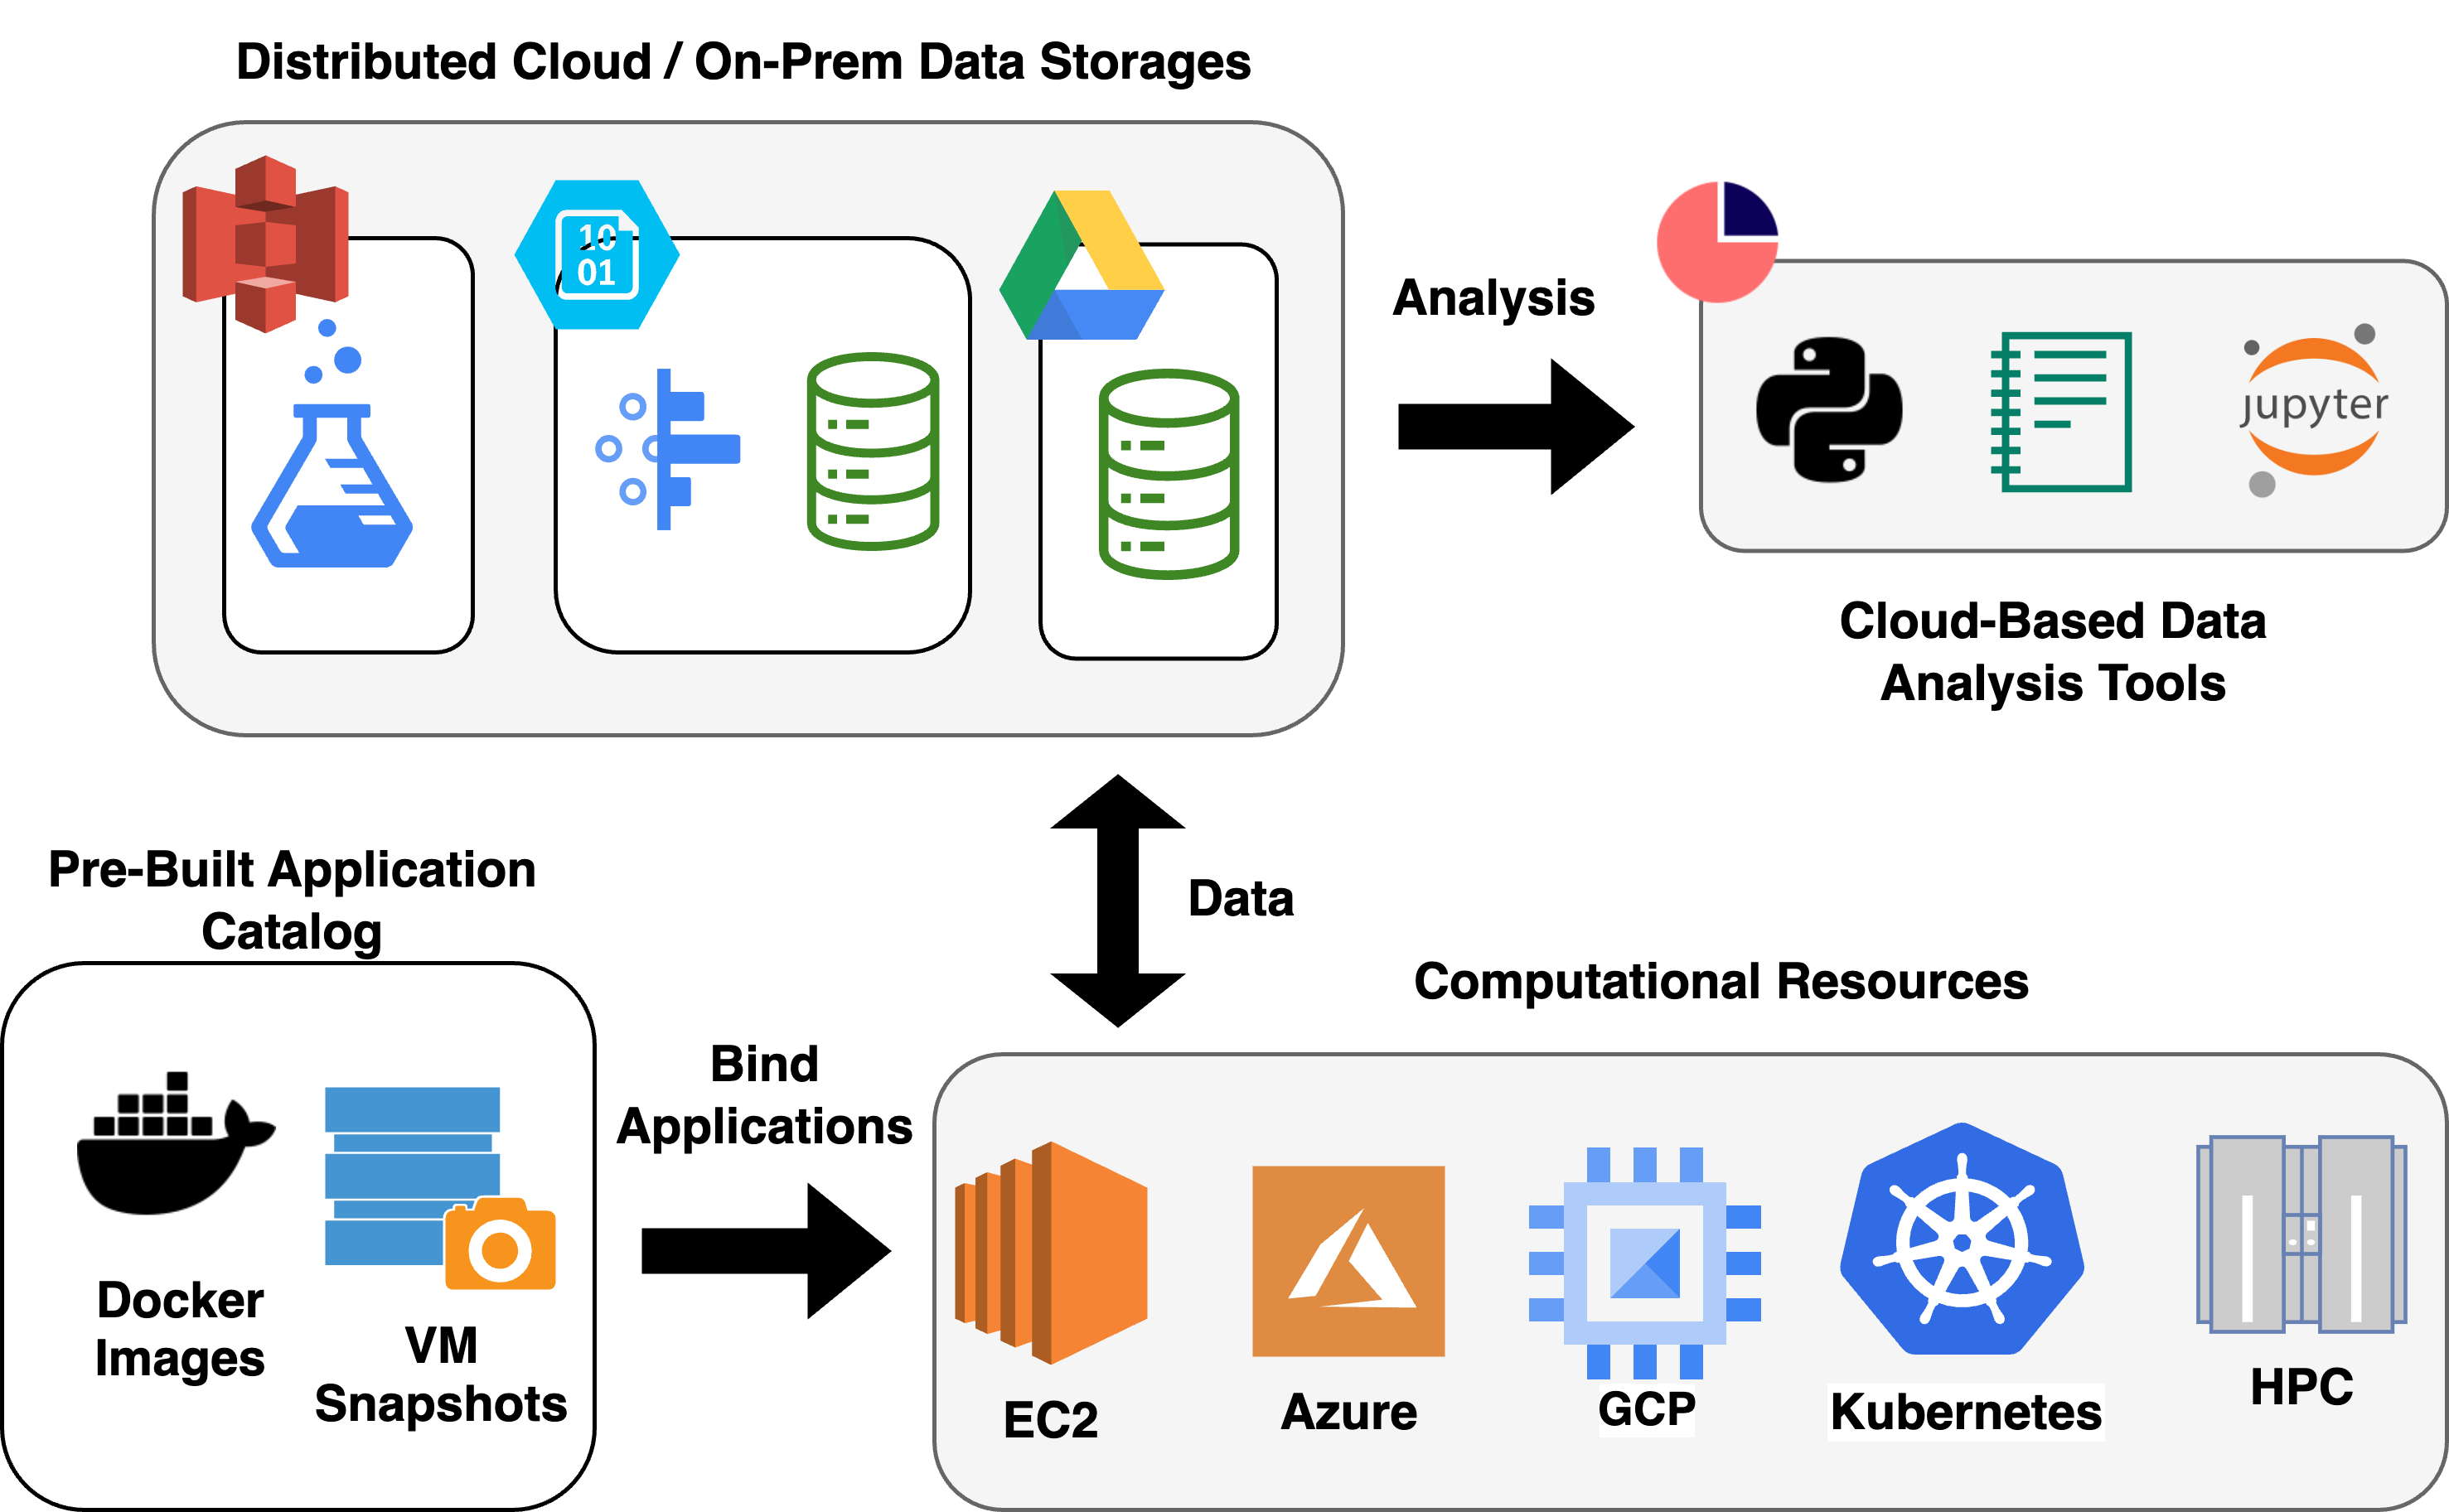

In [27]:
from IPython import display
display.Image("Computing_Platform-analyis.drawio.png")

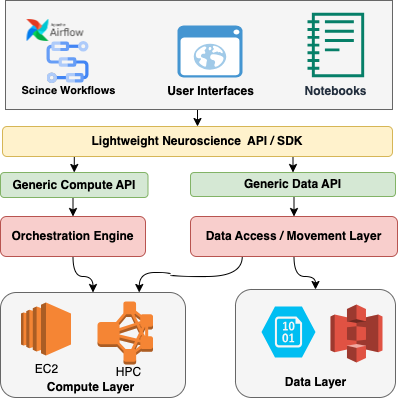

In [28]:
from IPython import display
display.Image("neuro-apis.drawio.png")

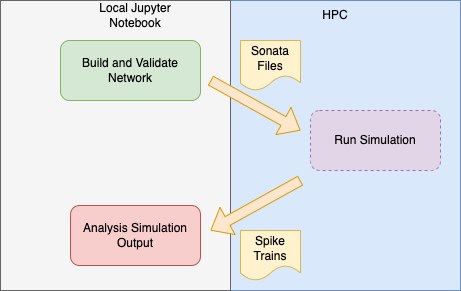

In [29]:
from IPython import display
display.Image("workflow.drawio.png")

In [30]:
from cybershuttle.annotations.decorator import CybershuttleHPCRun
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import h5py
import glob
import logging
import os


from bmtk.analyzer.spike_trains import plot_rates_boxplot, plot_rates, plot_raster
from bmtk.utils import sonata
from bmtk.utils.reports import SpikeTrains

logger = logging.getLogger("airavata_sdk.clients.utils.experiment_handler_util")

logger.setLevel(logging.INFO)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

In [31]:
@CybershuttleHPCRun(output="./output")
def load_v1_network_validate_run(input='./inputs'):
    net = sonata.File(
    data_files=input+'/network/l4_nodes.h5',
    data_type_files=input+'/network/l4_node_types.csv')
    l4_nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
    l4_nodes_df[['layer', 'ei', 'model_name',  'dynamics_params', 'model_template', 'model_type','node_id']]  \
    .groupby(['layer', 'ei', 'model_name', 'model_template', 'model_type', 'dynamics_params'])   \
    .agg('count')  \
    .rename(columns={'node_id':'node_count'})
    l4_edges_df = pd.read_csv(input+'/network/l4_l4_edge_types.csv', sep=' ').sort_values(['dynamics_params', 'target_query'])
    print(l4_nodes_df)
    with h5py.File(input+'/network/l4_l4_edges.h5', 'r') as h5:
      edge_ids, edge_counts = np.unique(h5['/edges/l4_to_l4/edge_type_id'][()], return_counts=True)
      edge_counts_df = pd.DataFrame({'edge_type_id': edge_ids, 'counts': edge_counts})
      l4_edges_df = l4_edges_df.merge(edge_counts_df, how='left', on='edge_type_id')

    l4_edges_df.set_index(['edge_type_id', 'target_query', 'source_query', 'dynamics_params'])
    print(l4_edges_df)
    print('Valid SONATA inputs:')
    for spikes_file in glob.glob(input+'/inputs/spikes.*.h5'):
       print('->', spikes_file)


Click on Login URI  https://neuroscience.cybershuttle.org/auth/login-desktop/?show-code=true
Copy paste the access token········


In [32]:
load_v1_network_validate_run(input='./inputs')

Executing user provided function...
      node_type_id  node_id  tuning_angle           x           y           z  \
0              100        0      0.000000  119.485001  384.989275  -56.577812   
1              100        1      3.050847  -73.669430  417.107342  166.282127   
2              100        2      6.101695   54.743024  403.567362  124.182278   
3              100        3      9.152542   14.297729  396.574152   48.710376   
4              100        4     12.203390 -129.647833  347.253059  -58.759062   
...            ...      ...           ...         ...         ...         ...   
2410           105     2410    353.513514   12.805991  358.970289 -167.841390   
2411           105     2411    355.135135  -43.409817  316.332169  134.711173   
2412           105     2412    356.756757   80.453753  324.341894   -2.457055   
2413           105     2413    358.378378 -138.086114  364.519788   11.219260   
2414           105     2414    360.000000  -72.441261  319.505839  -50.28

Dropdown(description='Select Compute Resources', options=('Bridges2', 'Expanse'), value='Bridges2')

Select Compute Resources Queue  Expanse


Dropdown(description='Select Compute Resources Queue', options=('compute', 'gpu', 'gpu-debug', 'gpu-shared', '…

selected compute resource queue  shared
Experiment name:  allen_v1_ybxt
local_data_directory:  ./inputs
output_data_directory:  ./output
scheduled compute resource:  Expanse
scheduled queue:  shared
Creating experiment ....


INFO:airavata_sdk.clients:creating experiment allen_v1_ybxt
INFO:airavata_sdk.clients:connnecting to file upload endpoint gf4.ucs.indiana.edu : 9003
INFO:airavata_sdk.clients:Input files uploaded to isjarana@iu.edu/Default_Project/allen_v1_ybxt_2023_06_21_12_20_03/
INFO:airavata_sdk.clients:configuring inputs ......
INFO:airavata_sdk.clients:experiment launched id: allen_v1_ybxt_6294f141-57a5-471f-a77a-5fd95a36a730
INFO:airavata_sdk.clients:For more information visit https://neuroscience-cybershuttle.org/workspace/experiments/allen_v1_ybxt_6294f141-57a5-471f-a77a-5fd95a36a730
INFO:airavata_sdk.clients:Initial state EXECUTING
INFO:airavata_sdk.clients:State EXECUTING
INFO:airavata_sdk.clients:State JOB_ACTIVE
INFO:airavata_sdk.clients:State JOB_ACTIVE
INFO:airavata_sdk.clients:State JOB_ACTIVE
INFO:airavata_sdk.clients:State COMPLETED
INFO:airavata_sdk.clients:Completed


In [33]:
def plot_tuning_angle_fr(input_path,spikes_path, fr_window=(500.0, 3000.0), avg_window=15):
    dur_secs = (fr_window[1] - fr_window[0]) / 1000.0

    net = sonata.File(
        data_files=input_path+'/network/l4_nodes.h5',
        data_type_files=input_path+'/network/l4_node_types.csv'
    )
    nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
    nodes_df = nodes_df[['node_id', 'node_type_id', 'model_name', 'tuning_angle', 'model_type', 'layer', 'ei']]
    
    spikes = SpikeTrains.load(spikes_path)
    spikes_df = spikes.to_dataframe(population='l4')

    fr_df = spikes_df['node_ids'][spikes_df.timestamps.between(fr_window[0],fr_window[1])] \
                                  .value_counts()  \
                                  .rename_axis('node_id')  \
                                  .reset_index(name='spike_counts')
    
    fr_df['firing_rates'] = fr_df['spike_counts'].values / dur_secs
    fr_df['node_id'] = fr_df['node_id'].astype(np.uint64)
    fr_df = fr_df.merge(nodes_df, how='right', on='node_id')       
    fr_df['spike_counts'] = fr_df['spike_counts'].fillna(0.0)   
    fr_df['firing_rates'] = fr_df['firing_rates'].fillna(0.0)
    
    def create_subplot(ax, grp_df, label):
        ax.scatter(grp_df['tuning_angle'], grp_df['firing_rates'], s=2)
        
        fr_avgs = pd.DataFrame({
            'tuning_rounded': np.floor(grp_df['tuning_angle']),
            'firing_rates': grp_df['firing_rates']
        }).groupby('tuning_rounded').agg(np.mean)
        
        if avg_window and len(fr_avgs['firing_rates']) > avg_window:
            tuning_even_spaced = pd.DataFrame({
                'tuning_rounded':np.arange(360)
            })
            fr_avgs=fr_avgs.merge(tuning_even_spaced, how='right', on='tuning_rounded')
            fr_avgs['firing_rates_avg'] = fr_avgs['firing_rates'].rolling(avg_window, min_periods=1).mean()

        ax.plot(fr_avgs['firing_rates_avg'], c='r', linewidth=3, label=label)
        ax.legend(fontsize=10, loc='upper right')
        ax.set_xlabel('Tuning Angle (deg)')
        ax.set_ylabel('Firing Rate (Hz)')

    # plot excitatory cells by layer
    nrows = 2
    fig, axes = plt.subplots(nrows, 1, figsize=(10, 5))
    for r, layer in enumerate(['VisL4']):
        exc_df = fr_df[(fr_df['ei'] == 'e') & (fr_df['layer'] == layer)]
        create_subplot(axes[r], exc_df, 'exc; {}'.format(layer))

    # plot inhibitory cells
    inh_df = fr_df[fr_df['ei'] == 'i']
    create_subplot(axes[r+1], inh_df, 'inh; ALL')

    for r in range(nrows):
        if r != (nrows - 1):
            axes[r].set_xticklabels([])
            
    plt.show()

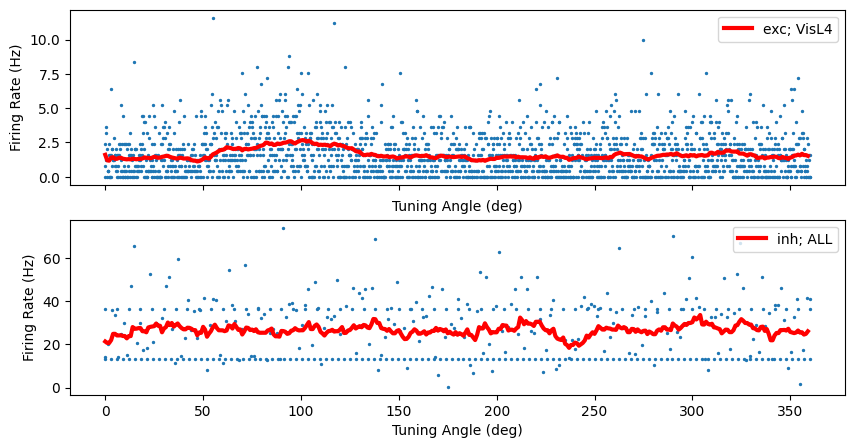

In [34]:
plot_tuning_angle_fr('./inputs','./output/allen_v1_ybxt_2023_06_21_12_20_03/ARCHIVE/output_feedforward/spikes.h5')